<center>
<h1>Факультет "Прикладная математика" МАИ</h1>
<h2>Курс "Основы Python для анализа данных"</h2>
<h2>Артамонов Игорь Михайлович</h2>
</center>

<center><h2>Занятие № 10. Деревья решений. k ближайших соседей.</h2></center>

## Общение / вопросы по курсу

Платформа для групповой работы Atlassian Confluence факультета "Прикладная математика"

https://mai.moscow/display/PYTML

* <b>Занятие № 10. Задачи машинного обучения. Деревья решений. k ближайших соседей.</b>

## virtualenv + Jupyter notebook

```
<Ctrl> + <Alt> + T - новое окно терминала
```

```
$ conda -V

$ conda update conda

$ conda search "^python$"

$ conda create -n yourenvname python=x.x anaconda

$ source activate yourenvname

$ jupyter notebook

$ conda install -n yourenvname [package]
```

##  Деревья решений. k ближайших соседей. Кросс-энтропия.  Выбор моделей.</h2></center>

#### Задачи машинного обучения
* регрессия
* классификация
* кластеризация

#### Обычный порядок действий
* получить "сырые" данные
* понять, что они из себя представляют (см. EDA)
* привести их в вид, пригодный для обучения модели
* разбить тренировочную выборку на две: обучающую и проверочную (валидационную)
* сравнить несколько алгоритмов машинного обучения, их настроек, чтобы получить наилучший результат для P на валидационной выборке
* (_возможно_) повторить предыдущие три этапа несколько раз
* обучить "лучшую" модель на всей тренировочной выборке
* использовать модель для получения каких-то результатов
* (_возможно_) провести дообучение модели с полученными свежими данными

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from numpy.random import randn
import seaborn as sns
from scipy import stats

%matplotlib inline

In [17]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [18]:
import os
import os.path

## Машинное обучение

__Определение.__ Мы считаем, что компьютерная программа __обучается__ при решении какой-то задачи из __класса  T__, если ее производительность, согласно __метрике P__, улучшается при накоплении __опыта E__.


T. Mitchell "Machine learning", 1997
https://www.cs.ubbcluj.ro/~gabis/ml/ml-books/McGrawHill%20-%20Machine%20Learning%20-Tom%20Mitchell.pdf

* есть класс задач T
* есть метрика производительности P
* есть понятие опыта E

Примеры задач:
* задача распзнавания изображений
* задача классификации новых объектов
* задача обучения игре

## <font color=green>ВОПРОС</font>

Где здесь __T, P__ и  __E__?

Алгоритмы машинного обучения делятся на:
* обучающиеся с учителем (__supervised__ learning).
* обучающиеся без учителя (__unsupervised__ learning).<br><br>

Общее в этих задачах - наличие некоторой выборки данных (информации об объектах), 
которую называют набором признаков (__object features__). При обучении без учителя
никакой дополнительной информации, связанной с __каждым объектом__ нет.

В случе обучения __с учителем__ с каждым из объектов связывается дополнительный
целевой признак. Это то, что хотелось бы прогнозировать для прочих объектов, 
не из обучающей выборки.

Основными задачами в машинном обучении являются:
* Обучение с учителем:
    - __регрессия__ – прогнозирование количественного признака объекта на основании прочих его признаков
    - __классификация__ – отнесение объекта к одной из категорий на основании его признаков<br><br>
* Обучение без учителя:
    - __кластеризация__ – разбиение множества объектов на группы на основании анализа признаков этих объектов так, чтобы внутри групп объекты были, в некотором смысле, более "близкими" между собой, а вне одной группы – менее "близкими"

Минимальный путь машинного обучения выглядит так:
* обучиться на обучающей выборке (получить опыт E) так, чтобы на этой выборке метрика P 
достигла своего экстремума
* применить полученный опыт E к новым данным (данным за пределами обучающей выборки), чтобы сделать что-то хорошее

Более адекватный (и реалистичный) путь машинного обучения выглядит так:
* определить цель обучения (business goal)
* определить критерий оценки (метрика, preformance measure)
* получить "сырые" данные
* понять, что они из себя представляют (см. EDA)
* привести их в вид, пригодный для обучения модели
* разбить тренировочную выборку на две: обучающую и проверочную (валидационную)
* сравнить несколько алгоритмов машинного обучения, их настроек, чтобы получить наилучший результат для P на валидационной выборке
* (_возможно_) повторить предыдущие три этапа несколько раз
* обучить "лучшую" модель на всей тренировочной выборке
* использовать модель для получения каких-то результатов
* (_возможно_) провести дообучение модели с полученными

## Sklearn

* одна из основных бибилотек, используемая при машинном обучении
* содержит много качественных алгоритмов и хорошую документацию
* имеет _типовую_ логику применения

* данные состоят из тренировочных и тестовых данных
* Делим тренировочную выборку на входные и выходные переменные
* Заполняем пропущенные данные (см. предыдущее занятие № 9)
* Фильтрация пропущенных данных
* Проверяем, остались ли не заполненные данные?
* Выполняем преобразование данных (смещенные распределения, логарифмирование и т.д.)
* Создаем признаки:
    * составные
    * бинарные
    * категориальные
* Создаем классификатор / регрессор
* Учим классификатор / регрессор на тренировочных данных с валидационными выборками
* Проверяем обучение классификатора на тестовой выборке
* Повторяем ...

## Метрики для регрессии. MSE / MAE 

#### Среднеквадратичное отклонение

$$ RMSE(X, h) = \ \frac{1}{n}\sum_{i=1}^{n} (h(x_i) - y_i)^2  $$

#### Среднее абсолютное отклонение

$$ MAE(X, h) = \ \frac{1}{n}\sum_{i=1}^{n} \lvert h(x_i) - y_i \rvert  $$

## Метрики для классификации. Кросс-энтропия

__Энтропия__ — это то, как много информации нам __не__ известно о системе. Это не __свойство системы__, это свойство __знания__ о системе.

#### Степень удивления
Степень, насколько мы удивлены, увидев результат
$$ s = \log \frac{1}{p_i} $$
где $p_i$ - вероятность $i$-го исхода<br><br>

#### Энтропия
Взвешенное среднее "удивления" от индивидуальных исходов
$$ e = \sum_{i=1}^{n} p_i * \log \frac{1}{p_i} = - \sum_{i=1}^{n} p_i * \log p_i $$
Если использовать основание логарифма, равное 2:
$$ e = - \sum_{i=1}^{n} p_i * \log_2 p_i $$
то эта формула также называется "информационной энтропией" или "энтропией Шеннона".


#### Кросс-энтропия
Взвешенное среднее "удивления" от индивидуальных исходов, когда вероятность остается $p_i$, однако
наблюдатель считает, что она равна $q_i$
$$ e = \sum_{i=1}^{n} p_i * log \frac{1}{q_i} = - \sum_{i=1}^{n} p_i * log \ q_i$$
Кросс-энтропия всегда __больше__ чем энтропия, за исключением случая, когда наблюдатель точно знает реальное распределение (тода $p_i = q_i$).

<img src="images10/cross-ent-01.png">

* фиолетовый "столбик" - площадь под синей кривой
* синяя кривая - кросс-энтропия
* красная кривая - реальное распределение вероятностей
* оранжевая кривая - ожидаемое распределение вероятностей

Для случая 2-х исходов (бинарная классификация - "да/нет", "истинно/ложно")
$$ e = \sum_{i=0}^{1} p_i * log \frac{1}{q_i} = 
   p_0 log \frac{1}{q_0} + p_1 log \frac{1}{q_1} = 
   - p_0 log \ q_0 - (1-p_0) log \ 1-q_0 
$$

## <font color="red">ЗАДАНИЕ</font>

Постройте:
* график, аналогичный приведенному
* график изменния кросс-энтропии для двух нормальных распределений с  $\sigma = 1$ в зависимости от расстояния между их матожиданиями

In [53]:
from scipy.stats import norm

mu = 0
sigma = 1
n_bins = 50
s = np.random.normal(mu, sigma, 1000)
b = np.random.normal(mu + 10, sigma, 1000)
cross = np.array(n_bins)
for i in range(n_bins):
    cross[i] = -1 * np.sum(s[i] * np.log(b[i]))



IndexError: too many indices for array

#### Неопределенность Джини (Gini impurity)
$$ G = 1 - \sum_{k} (p_k)^2$$
Максимизацию этого критерия можно интерпретировать как максимизацию числа пар
объектов одного класса, оказавшихся в одном поддереве

## Кросс-энтропия и деревья решений
Пример из  https://habr.com/post/171759/

Предположим, что нам надо найти правила разбиения набора данных таким образом, 
чтобы среднее значение энтропии уменьшалось. Это означает, что наше знание о системе __растет__ и этот процесс можно рассматривать как _производство информации_ ()

Если мы разбили исходный набор данных на две части по некому предикату, то можно рассчитать энтропию каждого подмножества. Если после среднее значение энтропии окажется меньшим чем энтропия исходного множества, значит предикат содержит некую обобщающую информацию о данных.

<img src="images10/cross-ent-02.png">

Если мы ограничены простыми предикатами, то одного условия будет недостаточно. Поэтому, 
если повторять эту процедуру рекурсивно для каждого подмножества, мы получим древовидный набор условий, 
который назвается __деревом принятия решений__ (decision tree).

<img src="images10/cross-ent-03.png">

* листьями дерева принятия решений являются _классы_
* классификация происходит путем спуска вниз по дереву
* процесс спуска можно трактовать как процесс _объяснения_, почему объект отнесен к тому или иному классу

## <font color=green>ВОПРОС</font>
* Можно ли использовать дерево для регрессии?
* Можно ли использовать дерево для кластеризации?

Параметры класса __sklearn.tree._DecisionTreeClassifier___

* __criterion__ (опционально):
    - функция оценки качества разбиеная (”gini” или "entropy")
* __splitter__ (опционально):
    - стратегия, используемая для разбиения в каждом узле (“best” - лучший вариент, “random” - случайное разбиение).
* __max_depth__ (опционально):
    - максимальная глубина дерева
* __min_samples_split__  (опционально):
    - минимальное количество примеров, требуемое для разбиения внутреннего узла.
* __random_state__  (опционально):
    - начальное значение (seed) для генератора случайных чисел

### Параметры дерева

## <font color=green>ВОПРОС</font>
* Зачем ограничивать глубину дерева?
* Зачем ограничивать минимальное количество записей в узле

Когда деревья строятся до максимальной глубины:
* композиция деревьев ("лес", в том числе - случайный (_random forest_)) - усреднение ответов
* стрижка дерева - отсечение вершин за счет сравнения качества дерева с данным разибением и без него

<img src="images10/dt_iterations.png">

<img src="images10/reg_dt_path.png">

## Метод ближайших соседей

В основе - выбор ближайших, по некоторому расстоянию, соседей. Предполагается, что каковы ближайшие соседи, 
таков и данный элемент. Метод часто используется как базовый или для построения мета-признаков 
(подается на вход другим моделям).

Алгоритм:
* вычислить попарное расстояние между объектами обучающей выборки
* выбрать $k$ элементов обучающей выборки, расстояние до которых минимально
* класс объекта - это класс, наиболее часто встречающийся среди $k$ ближайших соседей

Параметры метода ближайших соседей
* число соседей ($k$)
* метрика расстояний между объектами (евклидово расстояние, косинусное расстояние, метрика Хэмминга и др.)
* веса соседей (часто зависят от расстояний)

Параметры класса __sklearn.neighbors._KNeighborsClassifier___

* __weights__
    - _"uniform"_ - все веса равны
    - _"distance"_ - вес обратно пропорционален расстоянию до тестового примера
    - _другая_ определенная пользователем функция
* __algorithm__ (опционально):
    - _"auto"_ - выбирается автоматически
    - _"brute"_ - считаются полным перебором обучающей выборки
    - _"ball__tree"_ / KD_tree - расстояния хранятся в дереве, что ускоряет поиск соседей
* __leaf_size__ (опционально):
    - порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
* __metric__: 
    - _"minkowski"_, _"manhattan"_, _"euclidean"_, _"chebyshev"_ ...

## Кросс-валидация

Основная задача обучаемых алгоритмов - способность работать на новых данных. 
Для проверки обобщающей способности модели наиболее часто используются разбиение тренировочной выборки на две
части: собственно тренировочная (в которую попадает обычно 60-80% от всей выборки) и отложенная 
(проверочная, валидационная). 
Это разбиение может быть сделано несколькими способами:
* "вырезаем" непрерывную часть выборки нужного размера, остальные элементы используются для обучения
* выбираем некоторое количество элементов случайным образом и используем остальные для обучения
* делаем несколько последовательных выборок (непрерывных или случайных), чтобы улучшить нашу оценку
моделей за счет осреднения (кросс-валидация - _cross validation_)

## Кросс-валидация (K-Fold)

<img src="images10/cross-val-02.png">

используется для:
* выбора модели
* настройки параметров модели
* оценки полезности признаков
Основная проблема - высокая "цена" на больших выборках

Первые два способа реализуются __sklearn.model_selection.train_test_split__, вторые - __model_selection.KFold__

Для сохранения распределения целевых признаков по классам используются StratifiedKFold, StratifiedShuffleSplit

## Применение на базе данных рукописных цифр (MINST)

In [57]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target # 

X[1,:].reshape([8,8])

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

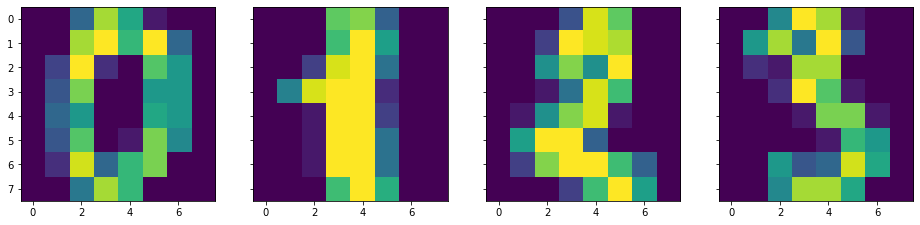

In [58]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]));

In [60]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17) 
#random_state - нужно перемешать значения 

In [62]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [70]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred) # (0.97, 0.666)

(0.9740740740740741, 0.6666666666666666)

In [72]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, iid=None)  #cv колич попыток, n_jobs колич ядер ситемы
# verbose - вывод отладочная инфа 

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid=None, n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30,

In [73]:
tree_grid.best_params_, tree_grid.best_score_ # ({'max_depth': 20, 'max_features': 64}, 0.844)

({'max_depth': 20, 'max_features': 64}, 0.8442508528266807)

In [74]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)) # 0.987  перекрестная классификация

0.9865458422397149

In [75]:
np.mean(cross_val_score(RandomForestClassifier(n_estimators=20, random_state=17), X_train, y_train, cv=5)) # 0.959

0.9595486890146592

In [76]:
np.mean(cross_val_score(GradientBoostingClassifier(n_estimators=200, random_state=17), X_train, y_train, cv=5)) # 0.953

0.9515500043933063

Перед домашним заданием __очень__ рекомендуется:
* перечитать https://habr.com/company/ods/blog/322534/
* сделать открытое задание к нему (__сдается на занятии!__ не присылать!):
http://nbviewer.jupyter.org/github/Yorko/mlcourse.ai/blob/master/jupyter_russian/assignments_demo/assignment03_decision_trees.ipynb
(+5 баллов, как и ДЗ)

## <font color="red">ЗАДАНИЕ</font>

* Загрузите датасет https://archive.ics.uci.edu/ml/datasets/Adult
* Применити к нему методы kNN, случайное дерево и ансамбль случайных деревьев



In [132]:
# Ваш код датасет adult.data
df = pd.read_csv("adult.data")


In [133]:
df.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [134]:
# TREE & KNN

In [135]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df[df.columns[1]] = le.fit_transform(df[df.columns[1]].values)
df[df.columns[3]] = le.fit_transform(df[df.columns[3]].values)
df[df.columns[5]] = le.fit_transform(df[df.columns[5]].values)
df[df.columns[6]] = le.fit_transform(df[df.columns[6]].values)
df[df.columns[7]] = le.fit_transform(df[df.columns[7]].values)
df[df.columns[8]] = le.fit_transform(df[df.columns[8]].values)
df[df.columns[9]] = le.fit_transform(df[df.columns[9]].values)
df[df.columns[13]] = le.fit_transform(df[df.columns[13]].values)

In [136]:
y = df[df.columns[14]]
X = df.drop(df.columns[14], axis=1)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17) 

In [137]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [138]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred) 

(0.7903357903357904, 0.8516584766584766)

In [139]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20],
'max_features': [1, 2, 3, 5, 10, 14]}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, iid=None) 
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid=None, n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20],
                         'max_features': [1, 2, 3, 5, 10, 14]},
             pre_disp

In [140]:
tree_grid.best_params_, tree_grid.best_score_ 

({'max_depth': 5, 'max_features': 14}, 0.8526234092214086)

## Домашнее задание (6 баллов)

Общая схема алгоритма:

In [142]:
# реализовать дерево принятия решений
# Передать ему данные и получить по тестовому датасету точность предсказания


```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t  
```

In [15]:
class DecisionTree(object):
    """
    В качестве функции потерь используйте логистическую функцию потерь, или же функцию потерь
    для кросс-энтропии sklearn.metrics.log_loss
    """
    def __init__(self, max_tree_depth, min_node_records):
        self.max_tree_depth = max_tree_depth
        self.min_node_records = min_node_records
        self.regression = regression

    def fit(self, X, y):
        """
        X - матрица входным параметров n x m
        y - вектор исходов n, каждое из которых имеет одно из ограниченного множества значений,
            определяющего класс
            
        Предполагается, что для элементов матрицы можно выполнять операции сравнения (<,=,>)

        После выполнения данной функции дерево должно быть обученным и способным предсказывать
        значение
        """
        pass

    def split(self, X, y):
        """
        Внутренняя функция. Разбивает матрицу на 2 смежные части, максимизируя критерий.
        """
        pass

    def predict(self, X):
        """
        Выводит вектор предсказаний для заданной матрицы X
        """

        pass    

## Экзаменационные вопросы:

* метрики, применямемые в классификации
* кросс-энтропия и неопределенность Джини
* принципы построения деревьев выбора
* метод k ближайших средних (kNN)
